# Computational Drug Discovery Project - MMP2

The ChEMBL bioactivity data acquired from the ChEMBL database will be utilized to build the machine learning models for this project.

## 1. Install and Import Libraries

The ChEMBL web service package will be utilized to obtain the ChEMBL bioactivity data for MMP2.

In [1]:
! pip install chembl_webresource_client

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import xgboost
import lightgbm
import lazypredict
import copy
import sklearn
import joblib
import pickle

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from padelpy import padeldescriptor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, StackingRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lazypredict.Supervised import LazyRegressor
from lightgbm import LGBMRegressor

## 2. Identify the Target Protein

In [3]:
# Target search for the MMP2 protein

target = new_client.target
target_query = target.search('mmp2')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P33434', 'xref_name': None, 'xre...",Mus musculus,Matrix metalloproteinase-2,14.00,False,CHEMBL3095,"[{'accession': 'P33434', 'component_descriptio...",SINGLE PROTEIN,10090
1,"[{'xref_id': 'P08253', 'xref_name': None, 'xre...",Homo sapiens,Matrix metalloproteinase-2,14.00,False,CHEMBL333,"[{'accession': 'P08253', 'component_descriptio...",SINGLE PROTEIN,9606
2,"[{'xref_id': 'P33436', 'xref_name': None, 'xre...",Rattus norvegicus,72 kDa type IV collagenase,14.00,False,CHEMBL1075175,"[{'accession': 'P33436', 'component_descriptio...",SINGLE PROTEIN,10116
3,[],Homo sapiens,Matrix metalloproteinase (2 and 3),12.00,False,CHEMBL2111321,"[{'accession': 'P08254', 'component_descriptio...",SELECTIVITY GROUP,9606
4,[],Homo sapiens,MMP-2/MMP-13,12.00,False,CHEMBL4523970,"[{'accession': 'P08253', 'component_descriptio...",SELECTIVITY GROUP,9606
5,[],Homo sapiens,MMP-2/MMP-14,11.00,False,CHEMBL4523971,"[{'accession': 'P50281', 'component_descriptio...",SELECTIVITY GROUP,9606
6,[],Homo sapiens,MMP-1/MMP-2,11.00,False,CHEMBL4523984,"[{'accession': 'P08253', 'component_descriptio...",SELECTIVITY GROUP,9606
7,[],Homo sapiens,Matrix metalloproteinase 2/9,10.00,False,CHEMBL3885505,"[{'accession': 'P08253', 'component_descriptio...",PROTEIN FAMILY,9606
8,[],Homo sapiens,MMP-2/MMP-9,10.00,False,CHEMBL4523972,"[{'accession': 'P08253', 'component_descriptio...",SELECTIVITY GROUP,9606
9,[],Homo sapiens,Collagenase,8.00,False,CHEMBL2095216,"[{'accession': 'P08253', 'component_descriptio...",PROTEIN FAMILY,9606


## 3. Retrieve the bioactivity data for Human Matrix Metalloproteinase-2

This is the second entry in the dataframe.

In [4]:
protein_target = targets.target_chembl_id[1]
protein_target

'CHEMBL333'

The bioactivity data for the selected protein_target, CHEMBL333, will be retrieved by filtering for the pChEMBL value.

In [5]:
activity = new_client.activity
res = activity.filter(target_chembl_id = protein_target).filter(standard_type = "IC50")

# The pChEMBL value for MMP2 in the ChEMBL database is standardized as "IC50."

In [6]:
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32565,[],CHEMBL716610,In vitro inhibitory activity against gelatinas...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,0.4
1,None,33270,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,0.3
2,None,33271,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,51.0
3,None,33272,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,150.0
4,None,33778,[],CHEMBL716610,In vitro inhibitory activity against gelatinas...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,None,23270303,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,4000.0
4283,None,23270304,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,1158.0
4284,None,23270305,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,20.0
4285,Not Active,23343297,[],CHEMBL4882414,Biochemical assay (FRET) with MMP2,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,µM,None,None,18.0


In [7]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32565,[],CHEMBL716610,In vitro inhibitory activity against gelatinas...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,0.4
1,None,33270,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,0.3
2,None,33271,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,51.0
3,None,33272,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,150.0
4,None,33778,[],CHEMBL716610,In vitro inhibitory activity against gelatinas...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,None,23270303,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,4000.0
4283,None,23270304,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,1158.0
4284,None,23270305,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,20.0
4285,Not Active,23343297,[],CHEMBL4882414,Biochemical assay (FRET) with MMP2,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,µM,None,None,18.0


In [8]:
len(df2.canonical_smiles.unique())

3716

In [9]:
# Remove any duplicate canonical_smiles from the dataframe

df2_unique = df2.drop_duplicates(['canonical_smiles'])
df2_unique

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32565,[],CHEMBL716610,In vitro inhibitory activity against gelatinas...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,0.4
1,None,33270,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,0.3
2,None,33271,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,51.0
3,None,33272,[],CHEMBL710563,Inhibitory activity against matrix metalloprot...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,uM,UO_0000065,None,150.0
4,None,33778,[],CHEMBL716610,In vitro inhibitory activity against gelatinas...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,None,23270301,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,3382.0
4281,None,23270302,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,2796.0
4282,None,23270303,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,4000.0
4283,None,23270304,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4835176,Inhibition of human recombinant MMP2 (AA34 to ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Matrix metalloproteinase-2,9606,None,None,IC50,nM,UO_0000065,None,1158.0


## 4. Data Preprocessing

### Combining selected columns into one DataFrame

This involves combining the 'molecule_chembl_id', 'canonical_smiles', 'standard_value', and bioactivity_class into one DataFrame.

In [10]:
columnselect = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
df3 = df2_unique[columnselect]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL151539,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...,0.4
1,CHEMBL443759,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...,300.0
2,CHEMBL95560,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...,51000.0
3,CHEMBL321088,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...,150000.0
4,CHEMBL151718,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...,0.7
...,...,...,...
4280,CHEMBL4877662,CC(C)C(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc...,3382.0
4281,CHEMBL4846457,CC1(CC(CO)C(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)NC(=...,2796.0
4282,CHEMBL4868710,COCC(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc(C...,4000.0
4283,CHEMBL4650334,C[C@H]1CN(C(=O)CC[C@@]2(C3CC3)NC(=O)NC2=O)CCN1...,1158.0


In [11]:
df3.to_csv('mmp2_preprocessed_data.csv', index = False)

### Label Activity Levels of Compounds

This will be done by creating a new column, 'class', and assigning each compound with either 'active', 'intermediate', or 'inactive.' This labeling is based on the IC50 value for the compound (represented in the dataframe as standard_value), which represents the bioactivity of each compound. In general, the smaller the IC50 value is, the more active the compound will be.

For this data, compounds with IC50 values equal to or less than 1000 nM will be labeled active, IC50 values between 1000 nM and 10000 nM will be intermediate, and values equal to or greater than 10000 nM will be inactive.

In [12]:
df4 = pd.read_csv('mmp2_preprocessed_data.csv')

In [13]:
# Create a function that determines the activity level for each compound based on the IC50/standard_value.

bioactivity_threshold = []
for i in df4.standard_value:
    if float(i) <= 1000:
        bioactivity_threshold.append("active")
    elif float(i) >= 10000:
        bioactivity_threshold.append("inactive")
    else:
        bioactivity_threshold.append("intermediate")

In [14]:
bioactivity_label_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df5 = pd.concat([df4, bioactivity_label_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL151539,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...,0.40,active
1,CHEMBL443759,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...,300.00,active
2,CHEMBL95560,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...,51000.00,inactive
3,CHEMBL321088,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...,150000.00,inactive
4,CHEMBL151718,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...,0.70,active
...,...,...,...,...
3711,CHEMBL4877662,CC(C)C(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc...,3382.00,intermediate
3712,CHEMBL4846457,CC1(CC(CO)C(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)NC(=...,2796.00,intermediate
3713,CHEMBL4868710,COCC(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc(C...,4000.00,intermediate
3714,CHEMBL4650334,C[C@H]1CN(C(=O)CC[C@@]2(C3CC3)NC(=O)NC2=O)CCN1...,1158.00,intermediate


In [15]:
# Save the new dataframe into a CSV file

df5.to_csv('mmp2_bioactivity_class_data.csv')

### Create a New DataFrame with Adjusted Canonical_Smiles Column

In [16]:
df5

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL151539,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...,0.40,active
1,CHEMBL443759,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...,300.00,active
2,CHEMBL95560,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...,51000.00,inactive
3,CHEMBL321088,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...,150000.00,inactive
4,CHEMBL151718,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...,0.70,active
...,...,...,...,...
3711,CHEMBL4877662,CC(C)C(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc...,3382.00,intermediate
3712,CHEMBL4846457,CC1(CC(CO)C(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)NC(=...,2796.00,intermediate
3713,CHEMBL4868710,COCC(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc(C...,4000.00,intermediate
3714,CHEMBL4650334,C[C@H]1CN(C(=O)CC[C@@]2(C3CC3)NC(=O)NC2=O)CCN1...,1158.00,intermediate


In [17]:
df_no_csmiles = df5.drop(columns = 'canonical_smiles')
df_no_csmiles

,molecule_chembl_id,standard_value,bioactivity_class
0,CHEMBL151539,0.40,active
1,CHEMBL443759,300.00,active
2,CHEMBL95560,51000.00,inactive
3,CHEMBL321088,150000.00,inactive
4,CHEMBL151718,0.70,active
...,...,...,...
3711,CHEMBL4877662,3382.00,intermediate
3712,CHEMBL4846457,2796.00,intermediate
3713,CHEMBL4868710,4000.00,intermediate
3714,CHEMBL4650334,1158.00,intermediate


In [18]:
# Create a function that can

smiles = []
for i in df5.canonical_smiles.to_list():
    cms = str(i).split('.')
    cms_longest = max(cms, key = len)
    smiles.append(cms_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [19]:
df_clean_csmiles = pd.concat([df_no_csmiles, smiles], axis=1)
df_clean_csmiles

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL151539,0.40,active,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...
1,CHEMBL443759,300.00,active,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...
2,CHEMBL95560,51000.00,inactive,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...
3,CHEMBL321088,150000.00,inactive,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...
4,CHEMBL151718,0.70,active,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...
...,...,...,...,...
3711,CHEMBL4877662,3382.00,intermediate,CC(C)C(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc...
3712,CHEMBL4846457,2796.00,intermediate,CC1(CC(CO)C(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)NC(=...
3713,CHEMBL4868710,4000.00,intermediate,COCC(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc(C...
3714,CHEMBL4650334,1158.00,intermediate,C[C@H]1CN(C(=O)CC[C@@]2(C3CC3)NC(=O)NC2=O)CCN1...


### Lipinski Descriptors

Lipinski Descriptors are values that describe the "drugability" of a molecule. The "drugability" of a molecule is based on the molecular properties that impact the pharmacokinetic and pharmacodynamic profiles of that molecule, and ultimately, the absorption, excretion, distribution, and metabolism of the molecule. The descriptors are related to Lipinski's Rule of Five, which describes the five important parameters - charge, hydrogen bonding, lipophilicity, molecular weight, and polar surface area - needed to improve the permeability of the blood brain barrier.

The four descriptors that will be utilized in this project include: molecular weight, log P, number of H-bond acceptors, and number of H-bond donors.

In [20]:
# Calculate the Lipinski Descriptors

def lipinski(smiles, verbose=False):

    moleculardata= []
    for element in smiles:
        mol=Chem.MolFromSmiles(element) 
        moleculardata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moleculardata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolWt","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [21]:
df_lipinski = lipinski(df_clean_csmiles.canonical_smiles)
df_lipinski

,MolWt,LogP,NumHDonors,NumHAcceptors
0,371.42,0.75,2.00,7.00
1,566.66,5.48,3.00,5.00
2,536.60,4.83,3.00,5.00
3,574.72,6.25,3.00,5.00
4,385.44,1.13,2.00,7.00
...,...,...,...,...
3711,441.36,2.90,2.00,4.00
3712,429.30,1.24,3.00,5.00
3713,443.33,1.89,2.00,5.00
3714,406.43,1.77,2.00,4.00


In [22]:
# Combine the two dataframes: lipinski_df and df5.

df_combined = pd.concat([df5, df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors
0,CHEMBL151539,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...,0.40,active,371.42,0.75,2.00,7.00
1,CHEMBL443759,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...,300.00,active,566.66,5.48,3.00,5.00
2,CHEMBL95560,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...,51000.00,inactive,536.60,4.83,3.00,5.00
3,CHEMBL321088,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...,150000.00,inactive,574.72,6.25,3.00,5.00
4,CHEMBL151718,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...,0.70,active,385.44,1.13,2.00,7.00
...,...,...,...,...,...,...,...,...
3711,CHEMBL4877662,CC(C)C(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc...,3382.00,intermediate,441.36,2.90,2.00,4.00
3712,CHEMBL4846457,CC1(CC(CO)C(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)NC(=...,2796.00,intermediate,429.30,1.24,3.00,5.00
3713,CHEMBL4868710,COCC(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc(C...,4000.00,intermediate,443.33,1.89,2.00,5.00
3714,CHEMBL4650334,C[C@H]1CN(C(=O)CC[C@@]2(C3CC3)NC(=O)NC2=O)CCN1...,1158.00,intermediate,406.43,1.77,2.00,4.00


### Tranform IC50 to pIC50

The IC50 value, or standard_value in the combined_df dataframe, is the minimum concentration of a molecule needed to elicit a half-maximal inhibitory response. The IC50 values will be transformed to pIC50 values to standardize the values in the dataframe.

In [23]:
# Create a function that convert the current value in nM to M units. Transform the new value into a negative logarithmic scale.

def pIC50(input):
    pIC50 = []
    
    for i in input['standard_value']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))
        
    input['pIC50'] = pIC50
    x = input.drop('standard_value', 1)
    
    return x

In [24]:
# View the minimum and maximum values of the current IC50 values
# There is a signficant difference between the minimum and maximum values

df_combined.standard_value.describe()

count       3716.00
mean       87535.35
std       568307.85
min            0.00
25%           24.00
50%         1000.00
75%        31000.00
max     15000000.00
Name: standard_value, dtype: float64

In [25]:
# Apply the dataframe with the current IC50 values to the pIC50 function

df_pIC50 = pIC50(df_combined)
df_pIC50

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL151539,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...,active,371.42,0.75,2.00,7.00,9.40
1,CHEMBL443759,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...,active,566.66,5.48,3.00,5.00,6.52
2,CHEMBL95560,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...,inactive,536.60,4.83,3.00,5.00,4.29
3,CHEMBL321088,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...,inactive,574.72,6.25,3.00,5.00,3.82
4,CHEMBL151718,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...,active,385.44,1.13,2.00,7.00,9.15
...,...,...,...,...,...,...,...,...
3711,CHEMBL4877662,CC(C)C(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc...,intermediate,441.36,2.90,2.00,4.00,5.47
3712,CHEMBL4846457,CC1(CC(CO)C(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)NC(=...,intermediate,429.30,1.24,3.00,5.00,5.55
3713,CHEMBL4868710,COCC(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc(C...,intermediate,443.33,1.89,2.00,5.00,5.40
3714,CHEMBL4650334,C[C@H]1CN(C(=O)CC[C@@]2(C3CC3)NC(=O)NC2=O)CCN1...,intermediate,406.43,1.77,2.00,4.00,5.94


In [26]:
# View the minimum and maximum pIC50 values after applying the pIC50 function
# There is now only a small difference between the minimum and maximum values after the pIC50 transformation

df_pIC50.pIC50.describe()

count   3716.00
mean       6.12
std        1.80
min        1.82
25%        4.51
50%        6.00
75%        7.62
max       11.40
Name: pIC50, dtype: float64

In [27]:
df_pIC50.to_csv('mmp2_bioactivity_data_pIC50.csv')

### Remove the 'intermediate' bioactivity_class

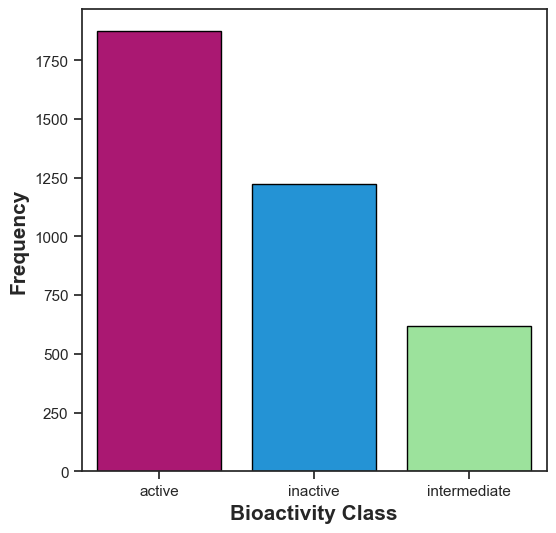

In [28]:
# Create a plot to view the number of molecules in each bioactivity class.

sns.set(style = 'ticks')

plt.figure(figsize=(6, 6))

sns.countplot(x='bioactivity_class', data = df_pIC50, edgecolor = 'black', palette = ['#C20078', '#069AF3', '#90EE90'])

plt.xlabel('Bioactivity Class', fontsize = 15, fontweight = 'bold')
plt.ylabel('Frequency', fontsize=15, fontweight = 'bold')

plt.savefig('freq_plot_bioactivity_3classes.pdf')

In [29]:
# Create a new dataframe that removes the intermediate bioactivity class.

df_2bioclass = df_pIC50[df_pIC50['bioactivity_class'] != 'intermediate']
df_2bioclass

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL151539,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...,active,371.42,0.75,2.00,7.00,9.40
1,CHEMBL443759,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...,active,566.66,5.48,3.00,5.00,6.52
2,CHEMBL95560,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...,inactive,536.60,4.83,3.00,5.00,4.29
3,CHEMBL321088,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...,inactive,574.72,6.25,3.00,5.00,3.82
4,CHEMBL151718,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...,active,385.44,1.13,2.00,7.00,9.15
...,...,...,...,...,...,...,...,...
3702,CHEMBL4877087,O=C1NC(=O)C(CCC(=O)N2CCN(c3cccc(Cl)c3)CC2)(C2C...,active,390.87,1.76,2.00,4.00,6.48
3704,CHEMBL4874226,O=C1NC(=O)C(CCC(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)...,inactive,462.34,2.55,2.00,5.00,4.70
3705,CHEMBL4863614,C[C@H]1CN(C(=O)CCC2(c3ccccn3)NC(=O)NC2=O)CCN1c...,inactive,476.36,2.94,2.00,5.00,4.70
3707,CHEMBL4862188,O=C1NC(=O)C(CCC(=O)N2CCN(c3ccc(F)c(Cl)c3)CC2)(...,active,445.88,2.04,2.00,5.00,6.20


In [30]:
df_2bioclass.to_csv('mmp2_bioactivity_data_pIC50_2bioclass.csv')

## 5. Exploratory Data Analysis

Exploratory data analysis will be utilized to compare the frequency of the two bioactivity classes (active and inactive) as well as the bioactivity classes with the Lipinski descriptors previously calculated.

### Frequency Plot of the Bioactivity Classes

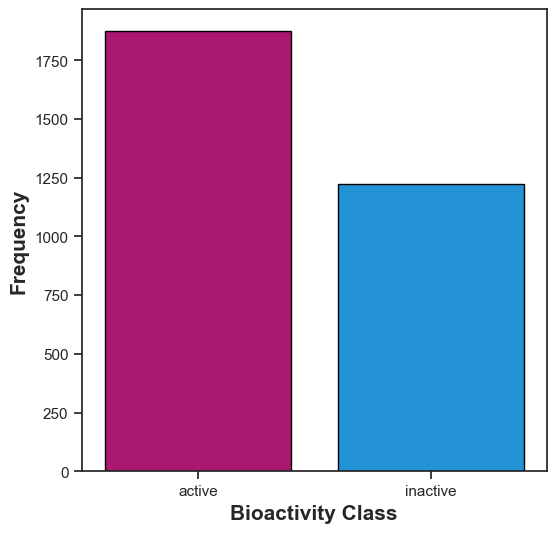

In [31]:
# Create a frequency plot to compare the number of molecules in each bioactivity class (active and inactive)

sns.set(style = 'ticks')

plt.figure(figsize=(6, 6))

sns.countplot(x='bioactivity_class', data = df_2bioclass, edgecolor = 'black', palette = ['#C20078', '#069AF3'])

plt.xlabel('Bioactivity Class', fontsize = 15, fontweight = 'bold')
plt.ylabel('Frequency', fontsize=15, fontweight = 'bold')

plt.savefig('freq_plot_bioactivity_class.pdf')

### Scatter Plot of Molecular Weight versus LogP

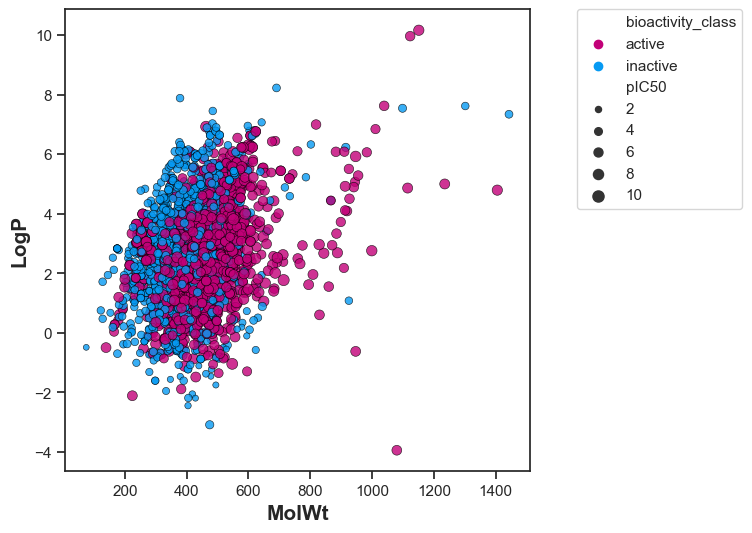

In [32]:
# Create a scatterplot of molecular weight versus LogP to compare lipophilicity differences of the molecules in each bioactivity class

plt.figure(figsize = (6, 6))

sns.scatterplot(x='MolWt', y = 'LogP', data=df_2bioclass, hue = 'bioactivity_class', edgecolor = 'black', size = 'pIC50', palette = ['#C20078', '#069AF3'], alpha = 0.8)

plt.xlabel('MolWt', fontsize = 15, fontweight = 'bold')
plt.ylabel('LogP', fontsize=15, fontweight = 'bold')
plt.legend(bbox_to_anchor = (1.1, 1), loc = 2, borderaxespad = 0)
plt.savefig('scatterplot_molwt_vs_logp.pdf')

### Mann-Whitney U Test

The Mann-Whitney U test can is a statistical test that compares two independent groups without requiring values to be normally distributed.

In [33]:
# Adopted from https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

def mannwhitneytest(descriptor, verbose=False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

# seed the random number generator
    seed(1)

# actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df = df_2bioclass[selection]
    active = df[df['bioactivity_class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'bioactivity_class']
    df = df_2bioclass[selection]
    inactive = df[df['bioactivity_class'] == 'inactive']
    inactive = inactive[descriptor]

# compare samples
    stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'
  
    results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

#### pIC50 Mann-Whitney U Test Results

In [34]:
# Apply the mannwhitneytest function to the 'pIC50' column

mannwhitneytest('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,2290028.00,0.00,0.05,Different distribution (reject H0)


#### Molecular Weight Mann-Whitney U Test Results

In [35]:
# Apply the mannwhitneytest function to the 'MolWt' column

mannwhitneytest('MolWt')

,Descriptor,Statistics,p,alpha,Interpretation
0,MolWt,1572463.50,0.00,0.05,Different distribution (reject H0)


#### LogP Mann-Whitney U Test Results

In [36]:
# Apply the mannwhitneytest function to the 'LogP' column

mannwhitneytest('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1088006.00,0.02,0.05,Different distribution (reject H0)


#### Number H Donors Mann-Whitney U Test Results

In [37]:
# Apply the mannwhitneytest function to the 'NumHDonors' column

mannwhitneytest('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1299769.50,0.00,0.05,Different distribution (reject H0)


#### Number H Acceptors Mann-Whitney U Test Results

In [38]:
# Apply the mannwhitneytest function to the 'NumHAcceptors column'

mannwhitneytest('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1333673.50,0.00,0.05,Different distribution (reject H0)


### Box Plots

#### pIC50 Values

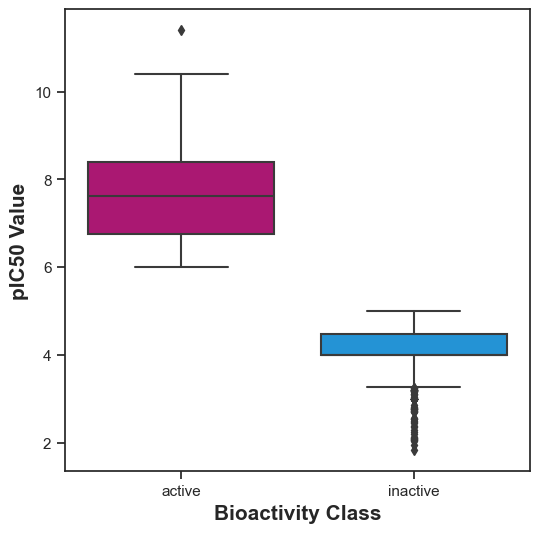

In [39]:
# Create a boxplot to compare the differences in pIC50 values for each bioactivity class

plt.figure(figsize=(6, 6))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2bioclass, palette = ['#C20078', '#069AF3'])

plt.xlabel('Bioactivity Class', fontsize = 15, fontweight = 'bold')
plt.ylabel('pIC50 Value', fontsize = 15, fontweight = 'bold')

plt.savefig('boxplot_pIC50.pdf')

#### Molecular Weight

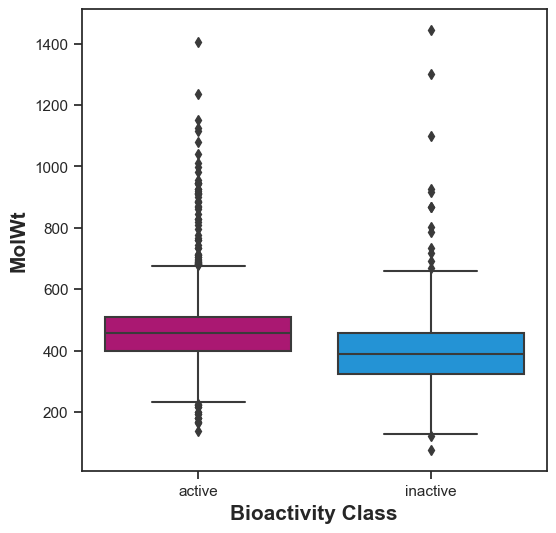

In [40]:
# Create a boxplot to compare the molecular weight of the molecules in each bioactivity class

plt.figure(figsize=(6, 6))

sns.boxplot(x = 'bioactivity_class', y = 'MolWt', data = df_2bioclass, palette = ['#C20078', '#069AF3'])

plt.xlabel('Bioactivity Class', fontsize = 15, fontweight = 'bold')
plt.ylabel('MolWt', fontsize=15, fontweight = 'bold')

plt.savefig('boxplot_molwt.pdf')

#### LogP

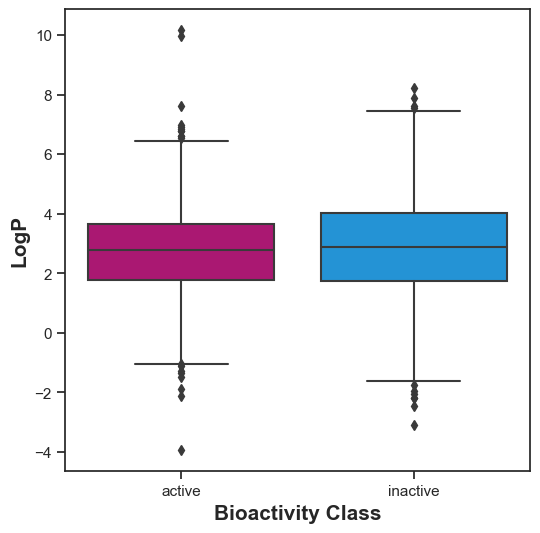

In [41]:
# Create a boxplot to compare the LogP values of the molecules in each bioactivity class

plt.figure(figsize=(6,6))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2bioclass, palette = ['#C20078', '#069AF3'])

plt.xlabel('Bioactivity Class', fontsize = 15, fontweight = 'bold')
plt.ylabel('LogP', fontsize = 15, fontweight = 'bold')

plt.savefig('boxplot_LogP.pdf')

#### Number H Donors

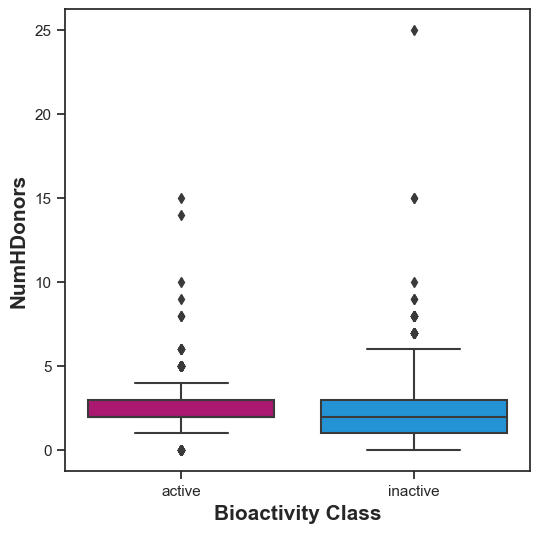

In [42]:
# Create a boxplot to compare the number of hydrogen donors in each bioactivity class

plt.figure(figsize=(6, 6))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2bioclass, palette = ['#C20078', '#069AF3'])

plt.xlabel('Bioactivity Class', fontsize = 15, fontweight = 'bold')
plt.ylabel('NumHDonors', fontsize = 15, fontweight = 'bold')

plt.savefig('boxplot_NumHDonors.pdf')

#### Number H Acceptors

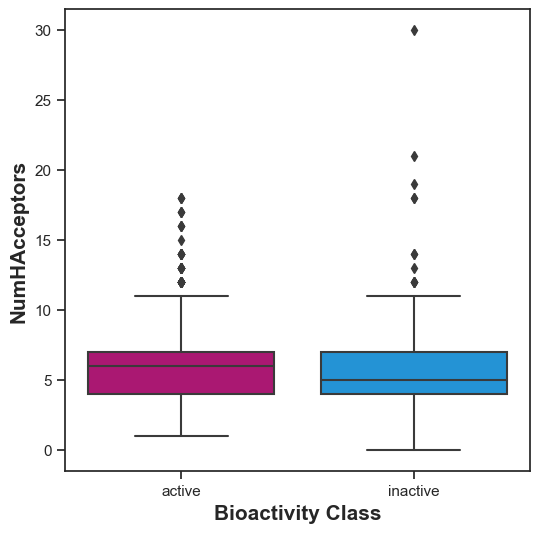

In [43]:
# Create a boxplot to compare the number of hydrogen acceptors in each bioactivity class

plt.figure(figsize=(6,6))

sns.boxplot(x = 'bioactivity_class', y ='NumHAcceptors', data = df_2bioclass, palette = ['#C20078', '#069AF3'])

plt.xlabel('Bioactivity Class', fontsize = 15, fontweight = 'bold')
plt.ylabel('NumHAcceptors', fontsize = 15, fontweight = 'bold')

plt.savefig('boxplot_NumHAcceptors.pdf')

### Statistical Results

#### pIC50 Values

Based on the pIC50 boxplot, there appears to be a statistically significant difference between the two bioactivity classes, active and inactive. This is plausible, however, as the range for the two classes varies significantly - the active class was defined to have IC50 values <= 1000 nM whereas the inactive class was defined to have IC50 values >= 10000 nM. From the pIC50 boxplot, this corresponds to the active class having values >= 6 and the inactive class having values <= 5.

#### Lipinski Descriptors

All four Lipinski descriptors evaluated (molecular weight, LogP, number hydrogen donors, and number hydrogen acceptors) display statistically significant differences. This is confirmed by the results from both the Mann Whitney U test and the boxplots.

## 6. Descriptor Calculation and Model Preparation

Molecular descriptors for the dataset will be calculated based on the fingerprint types compatible with PaDEL.

The df_pIC50 data will be utilized as it contains all values and does not remove the intermediate bioactivity class.

In [44]:
# View the df_pIC50 dataframe

df_pIC50

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL151539,CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO...,active,371.42,0.75,2.00,7.00,9.40
1,CHEMBL443759,O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1c...,active,566.66,5.48,3.00,5.00,6.52
2,CHEMBL95560,CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1c...,inactive,536.60,4.83,3.00,5.00,4.29
3,CHEMBL321088,CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1...,inactive,574.72,6.25,3.00,5.00,3.82
4,CHEMBL151718,COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(...,active,385.44,1.13,2.00,7.00,9.15
...,...,...,...,...,...,...,...,...
3711,CHEMBL4877662,CC(C)C(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc...,intermediate,441.36,2.90,2.00,4.00,5.47
3712,CHEMBL4846457,CC1(CC(CO)C(=O)N2CCN(c3cc(Cl)cc(Cl)c3)CC2)NC(=...,intermediate,429.30,1.24,3.00,5.00,5.55
3713,CHEMBL4868710,COCC(CC1(C)NC(=O)NC1=O)C(=O)N1CCN(c2cc(Cl)cc(C...,intermediate,443.33,1.89,2.00,5.00,5.40
3714,CHEMBL4650334,C[C@H]1CN(C(=O)CC[C@@]2(C3CC3)NC(=O)NC2=O)CCN1...,intermediate,406.43,1.77,2.00,4.00,5.94


Upload the individual fingerprint files.

Each file contains a fingerprint type that can be input into PaDEL to generate the descriptors for a dataset.

In [45]:
# Create a new file with the individual fingerprint *.xml files

xml_file = glob.glob("*.xml")
xml_file.sort()
xml_file

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [46]:
FP_list = ['AtomPairs2DCount', 'AtomPairs2D', 'EState', 'CDKextended', 'CDK', 'CDKgraphonly', 'KlekotaRothCount', 'KlekotaRoth', 'MACCS', 'PubChem', 'SubstructureCount', 'Substructure']

### Dictionary of the fingerprint files

In [47]:
# Create a dictionary of all twelve fingerprint files/types

fp = dict(zip(FP_list, xml_file))
fp

{'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml',
 'Substructure': 'SubstructureFingerprinter.xml'}

### Prepare the fingerprint file

In [48]:
# Select the 'canonical_smiles' and 'molecule_chembl_id' columns from the df_pIC50 dataframe
# The 'canonical_smiles' generates the descriptor and the 'molecule_chembl_id' helps identify the descriptor
# Create a *.smi file to input into PaDEL to generate the descriptors

fp_selection = ['canonical_smiles', 'molecule_chembl_id']
df_pIC50_selection = df_pIC50[fp_selection]
df_pIC50_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [49]:
! cat molecule.smi | head -5

CCCOc1ccc(S(=O)(=O)N2C/C(=N\OC)C[C@@H]2C(=O)NO)cc1	CHEMBL151539
O=C(CN(Cc1ccccc1)C(=O)CN(CCCc1ccccc1)C(=O)Nc1ccc(Oc2ccccc2)cc1)NO	CHEMBL443759
CCCCN(CC(=O)NO)C(=O)CN(CCc1ccc(F)cc1)C(=O)Nc1ccc(Oc2ccccc2)cc1	CHEMBL95560
CCCCCCCN(CC(=O)NO)C(=O)CN(CCCc1ccccc1)C(=O)Nc1ccc(Oc2ccccc2)cc1	CHEMBL321088
COc1ccc(S(=O)(=O)N2C/C(=N\OC(C)(C)C)C[C@@H]2C(=O)NO)cc1	CHEMBL151718
cat: stdout: Broken pipe


In [50]:
! cat molecule.smi | wc -l

    3716


### Calculate the Fingerprint Descriptors with PadelPY

Padelpy is a Python wrapper for the PaDEL-descriptor molecular descriptor software. It will be used to generate the molecular descriptors based on the canonical_smiles structures.

In [51]:
# Use the PubChem fingerprint to generate the descriptors for the dataset

fingerprint = 'PubChem'

fingerprint_output_csv = ''.join([fingerprint, '.csv'])
fingerprint_descriptors = fp[fingerprint]

padeldescriptor(mol_dir = 'molecule.smi', d_file = fingerprint_output_csv, descriptortypes = fingerprint_descriptors, 
                detectaromaticity = True, standardizenitro = True, standardizetautomers = True, threads = 2, removesalt = True, log = True, fingerprints = True)

In [52]:
fp_descriptors = pd.read_csv(fingerprint_output_csv)
fp_descriptors

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL151539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL443759,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL95560,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL321088,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL151718,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,CHEMBL4877662,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3712,CHEMBL4846457,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3713,CHEMBL4868710,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3714,CHEMBL4650334,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create the X and Y Data Matrices

#### X Data Matrix

In [53]:
# Drop the 'Name' column from dataframe for the X matrix as it is not useful for the machine learning model

df_X = fp_descriptors.drop(columns = ('Name'))
df_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3712,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3713,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3714,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Y Data Matrix

In [54]:
# Select the 'pIC50' column from the original dataframe (df_pIC50) for the Y matrix

df_y = df_pIC50['pIC50']
df_y

0      9.40
1      6.52
2      4.29
3      3.82
4      9.15
       ... 
3711   5.47
3712   5.55
3713   5.40
3714   5.94
3715   4.70
Name: pIC50, Length: 3716, dtype: float64

### Combine X and Y Matrices

In [55]:
# Combine the 

xy_matrix = pd.concat([df_X, df_y], axis=1)
xy_matrix

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.40
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.52
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.29
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.82
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3711,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.47
3712,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.55
3713,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.40
3714,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.94


In [56]:
# Save the combined X and Y matrices dataset as a CSV file

xy_matrix.to_csv('mmp2_bioactivity_pIC50_pubchem_fingerprint.csv', index=False)

### Prepare the ML Model Input and Output Features

#### Input Features - X Variable

In [57]:
# The df_X dataframe will be utilized as the input feature (X variable) for the machine learning model

X = df_X
X.shape

(3716, 881)

#### Output Features - Y Variable

In [58]:
# The df_Y dataframe will be utilized as the output feature (the Y variable) for the machine learning model

y = df_y
y.shape

(3716,)

### Remove Low Variance Data

In [59]:
# Remove the low variance data from the X variable

lowvar_selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = lowvar_selection.fit_transform(X)

In [60]:
X.shape

(3716, 145)

## 7. Machine Learning Models

The X and Y datasets will be utilized to create machine learning models.

The LazyPredict library will first be utilized to determine which models will likely perform best on the dataset. The individual models will be chosen and tested against the dataset separately following review of the LazyPredict results.

### Split the Data into Training and Testing Sets

The data will be split using a 80/20 ratio.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [62]:
X_train.shape, y_train.shape

((2972, 145), (2972,))

In [63]:
X_test.shape, y_test.shape

((744, 145), (744,))

### Compare ML Regression Algorithms with LazyPredict

In [64]:
# The Quantile Regressor in lazypredict will be removed for this test as it does not function properly on the dataset

a = lazypredict.Supervised.REGRESSORS

b = copy.copy(a)

for item in a:
    if item == ('QuantileRegressor', sklearn.linear_model._quantile.QuantileRegressor):
        b.remove(item)
a = copy.copy(b)

lazypredict.Supervised.REGRESSORS = a

In [65]:
# Use LazyRegressor from LazyPredict to compute multiple machine learning regression algorithms on the data

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.58,0.66,1.03,1.74
LGBMRegressor,0.58,0.66,1.03,0.52
RandomForestRegressor,0.55,0.64,1.07,2.77
XGBRegressor,0.53,0.62,1.09,0.79
SVR,0.52,0.61,1.11,0.97
NuSVR,0.51,0.61,1.11,0.76
BaggingRegressor,0.51,0.60,1.12,0.30
KNeighborsRegressor,0.48,0.58,1.15,0.11
MLPRegressor,0.46,0.57,1.17,3.76


### LazyPredict Model Performance Results Visualization

#### Barplot of the R-Squared Values

[(0.0, 1.0)]

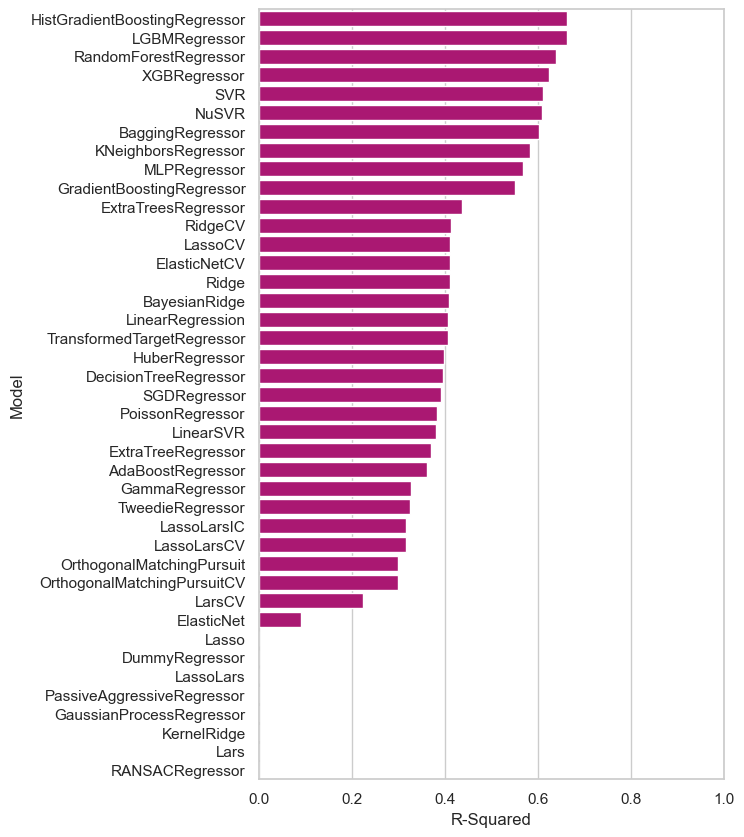

In [66]:
plt.figure(figsize=(6,10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="R-Squared", y=models.index, data=models, color='#C20078')
ax.set(xlim=(0,1))

#### Barplot of the RMSE Values

[(0.0, 12.0)]

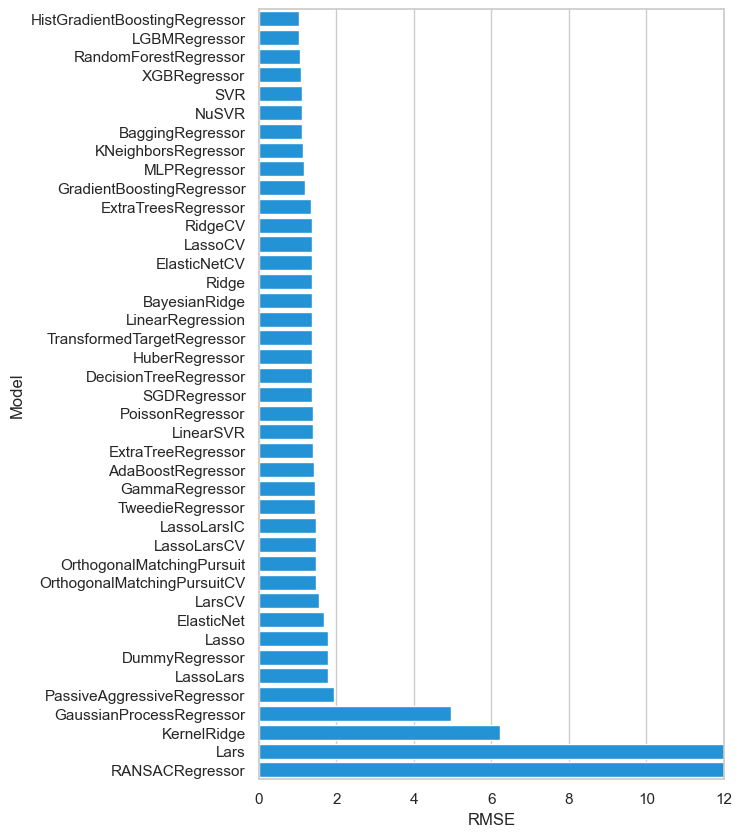

In [67]:
plt.figure(figsize=(6,10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = "RMSE", y=models.index, data=models, color='#069AF3')
ax.set(xlim=(0,12))

### Model 1: HIstogram Gradient Boosting Regressor Model

In [68]:
# Create a histogram gradient boosting regressor model with the previously split 80/20 data

hgb_model = HistGradientBoostingRegressor().fit(X_train, y_train)

hgb_predictions = hgb_model.predict(X_test)

#### Calculate Model Performance Metrics for Histogram Gradient Boosting

In [69]:
# Calculate the mean absolute error (MAE)

hgb_mae = mean_absolute_error(y_test, hgb_predictions)
hgb_mse = mean_squared_error(y_test, hgb_predictions)
hgb_rmse = np.sqrt(hgb_mse)
hgb_r2 = r2_score(y_test, hgb_predictions)

In [70]:
# Prepare a dataframe with the model performance metrics

data = ({'Model': "HistGradientBoostingRegressor", 'Mean Absolute Error': hgb_mae, 'Mean Squared Error': hgb_mse, 'Root Mean Squared Error': hgb_rmse, 'R^2 (R Squared)': hgb_r2})
metric_results = pd.DataFrame(data, index = [0])
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66


#### Scatterplot of the Experimental and Predicted pIC50 Results for Histogram Gradient Boosting

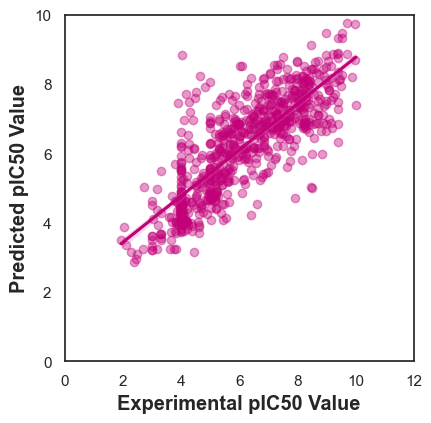

In [71]:
sns.set(color_codes=True)
sns.set_style("white")

results = sns.regplot(x = y_test, y = hgb_predictions, scatter_kws={'alpha':0.4}, color = '#C20078')
results.set_xlabel('Experimental pIC50 Value', fontsize='large', fontweight='bold')
results.set_ylabel('Predicted pIC50 Value', fontsize='large', fontweight='bold')
results.set_xlim(0,12)
results.set_ylim(0,10)
results.figure.set_size_inches(4.5,4.5)
plt.show

plt.savefig('hgb_results.pdf')

### Model 2: LightGBM Regressor

In [72]:
# Create a lightGBM regression model with the previously split 80/20 data

lightGBM_model = LGBMRegressor().fit(X_train, y_train)

lgbm_predictions = lightGBM_model.predict(X_test)

#### Calculate Model Performance Metrics for LightGBM

In [73]:
lgbm_mae = mean_absolute_error(y_test, lgbm_predictions)
lgbm_mse = mean_squared_error(y_test, lgbm_predictions)
lgbm_rmse = np.sqrt(lgbm_mse)
lgbm_r2 = r2_score(y_test, lgbm_predictions)

In [74]:
metric_results.loc[len(metric_results.index)] = ['LightGBM', lgbm_mae, lgbm_mse, lgbm_rmse, lgbm_r2]
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66
1,LightGBM,0.77,1.06,1.03,0.66


#### Scatterplot of the Experimental and Predicted pIC50 Results for LightGBM

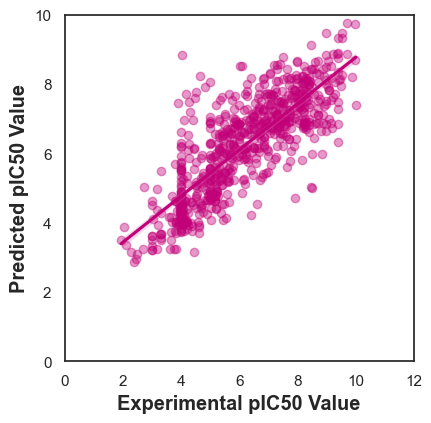

In [75]:
sns.set(color_codes=True)
sns.set_style("white")

results = sns.regplot(x = y_test, y = lgbm_predictions, scatter_kws={'alpha':0.4}, color = '#C20078')
results.set_xlabel('Experimental pIC50 Value', fontsize='large', fontweight='bold')
results.set_ylabel('Predicted pIC50 Value', fontsize='large', fontweight='bold')
results.set_xlim(0,12)
results.set_ylim(0,10)
results.figure.set_size_inches(4.5,4.5)
plt.show

plt.savefig('lgbm_results.pdf')

### Model 3: Random Forest Regression Model

In [76]:
# Create a random forest regression model with the previously split 80/20 data

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

#### Calculate Model Performance Metrics for Random Forest

In [77]:
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

In [78]:
metric_results.loc[len(metric_results.index)] = ['Random Forest', rf_mae, rf_mse, rf_rmse, rf_r2]
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66
1,LightGBM,0.77,1.06,1.03,0.66
2,Random Forest,0.77,1.13,1.06,0.64


#### Scatterplot of the Experimental and Predicted pIC50 Results for Random Forest

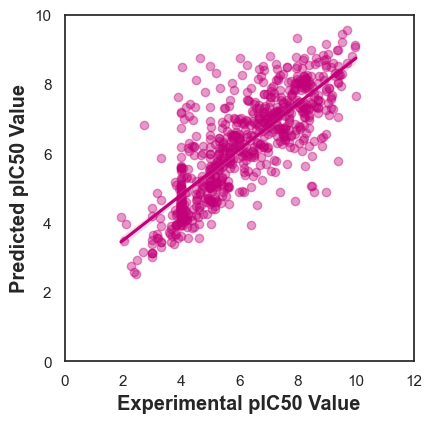

In [79]:
sns.set(color_codes=True)
sns.set_style("white")

results = sns.regplot(x = y_test, y = rf_predictions, scatter_kws={'alpha':0.4}, color = '#C20078')
results.set_xlabel('Experimental pIC50 Value', fontsize='large', fontweight='bold')
results.set_ylabel('Predicted pIC50 Value', fontsize='large', fontweight='bold')
results.set_xlim(0,12)
results.set_ylim(0,10)
results.figure.set_size_inches(4.5,4.5)
plt.show

plt.savefig('rf_results.pdf')

### Model 4: Extreme Gradient Boosting (XGBoost) Regressor

In [80]:
# Create a random forest regression model with the previously split 80/20 data

xgb_model = GradientBoostingRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

#### Calculate Model Performance Metrics for XGBoost

In [81]:
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [82]:
metric_results.loc[len(metric_results.index)] = ['XGBoost', xgb_mae, xgb_mse, xgb_rmse, xgb_r2]
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66
1,LightGBM,0.77,1.06,1.03,0.66
2,Random Forest,0.77,1.13,1.06,0.64
3,XGBoost,0.93,1.41,1.19,0.55


#### Scatterplot of the Experimental and Predicted pIC50 Results for XGBoost

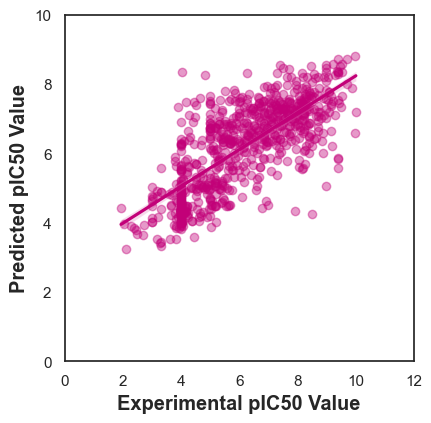

In [83]:
sns.set(color_codes=True)
sns.set_style("white")

results = sns.regplot(x = y_test, y = xgb_predictions, scatter_kws={'alpha':0.4}, color = '#C20078')
results.set_xlabel('Experimental pIC50 Value', fontsize='large', fontweight='bold')
results.set_ylabel('Predicted pIC50 Value', fontsize='large', fontweight='bold')
results.set_xlim(0,12)
results.set_ylim(0,10)
results.figure.set_size_inches(4.5,4.5)
plt.show

plt.savefig('xgboost_results.pdf')

### Model 5: Support Vector Regression (SVR)

In [84]:
# Create a support vector regression model with the previously split 80/20 data

svr_model = SVR().fit(X_train, y_train)

svr_predictions = svr_model.predict(X_test)

#### Calculate Model Performance Metrics for SVR

In [85]:
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(y_test, svr_predictions)

In [86]:
metric_results.loc[len(metric_results.index)] = ['SVR', svr_mae, svr_mse, svr_rmse, svr_r2]
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66
1,LightGBM,0.77,1.06,1.03,0.66
2,Random Forest,0.77,1.13,1.06,0.64
3,XGBoost,0.93,1.41,1.19,0.55
4,SVR,0.81,1.25,1.12,0.60


#### Scatterplot of the Experimental and Predicted pIC50 Results for SVR

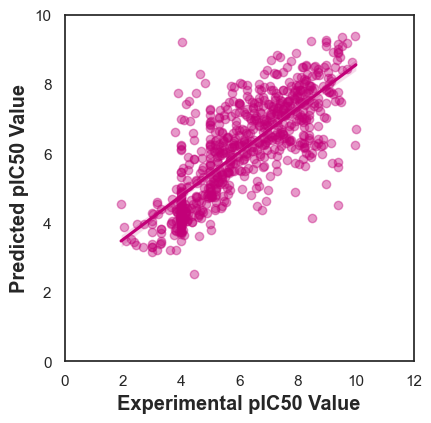

In [87]:
sns.set(color_codes=True)
sns.set_style("white")

results = sns.regplot(x = y_test, y = svr_predictions, scatter_kws={'alpha':0.4}, color = '#C20078')
results.set_xlabel('Experimental pIC50 Value', fontsize='large', fontweight='bold')
results.set_ylabel('Predicted pIC50 Value', fontsize='large', fontweight='bold')
results.set_xlim(0,12)
results.set_ylim(0,10)
results.figure.set_size_inches(4.5,4.5)
plt.show

plt.savefig('svr_results.pdf')

### Model 6: Bagging Regressor

In [88]:
# Create a bagging regressor model with the previously split 80/20 data

bag_model = BaggingRegressor().fit(X_train, y_train)

bag_predictions = bag_model.predict(X_test)

#### Calculate Model Performance Metrics for Bagging Regression

In [89]:
bag_mae = mean_absolute_error(y_test, bag_predictions)
bag_mse = mean_squared_error(y_test, bag_predictions)
bag_rmse = np.sqrt(bag_mse)
bag_r2 = r2_score(y_test, bag_predictions)

In [90]:
metric_results.loc[len(metric_results.index)] = ['Bagging Regressor', bag_mae, bag_mse, bag_rmse, bag_r2]
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66
1,LightGBM,0.77,1.06,1.03,0.66
2,Random Forest,0.77,1.13,1.06,0.64
3,XGBoost,0.93,1.41,1.19,0.55
4,SVR,0.81,1.25,1.12,0.60
5,Bagging Regressor,0.81,1.27,1.13,0.60


#### Scatterplot of the Experimental and Predicted pIC50 Results for Bagging Regression

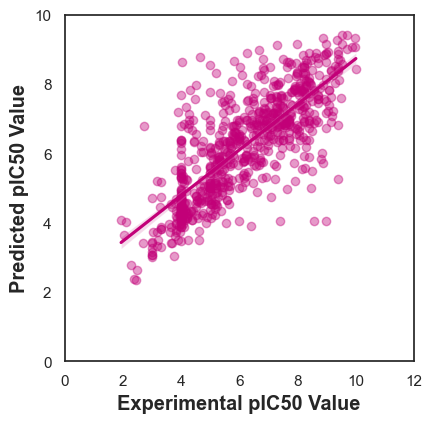

In [91]:
sns.set(color_codes=True)
sns.set_style("white")

results = sns.regplot(x = y_test, y = bag_predictions, scatter_kws={'alpha':0.4}, color = '#C20078')
results.set_xlabel('Experimental pIC50 Value', fontsize='large', fontweight='bold')
results.set_ylabel('Predicted pIC50 Value', fontsize='large', fontweight='bold')
results.set_xlim(0,12)
results.set_ylim(0,10)
results.figure.set_size_inches(4.5,4.5)
plt.show

plt.savefig('bag_results.pdf')

### Create a Stacked Model

In [92]:
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66
1,LightGBM,0.77,1.06,1.03,0.66
2,Random Forest,0.77,1.13,1.06,0.64
3,XGBoost,0.93,1.41,1.19,0.55
4,SVR,0.81,1.25,1.12,0.60
5,Bagging Regressor,0.81,1.27,1.13,0.60


The results indicate that the models have simialr performance metrics. A stacked model will be created that combines each individual model to determine if better performance metrics can be obtained.

In [93]:
# Define the estimators for the stacked model.
# The estimators will be the four models previously individually tested: HistGradientBoosting, lightGBM, random forest, and XGBoost

models = list()
models.append(('hgb', HistGradientBoostingRegressor()))
models.append(('lgbm', LGBMRegressor()))
models.append(('rf', RandomForestRegressor()))
models.append(('xgb', GradientBoostingRegressor()))
models.append(('svr', SVR()))
models.append(('bag', BaggingRegressor()))

In [94]:
# Define the meta learner model

meta_learner = LinearRegression()

In [95]:
# Define the stacking ensemble and apply it to the data

model = StackingRegressor(estimators = models, final_estimator=meta_learner)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

#### Calculate Model Performance Metrics for the Stacked Model

In [96]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

In [97]:
metric_results.loc[len(metric_results.index)] = ['Stacked', mae, mse, rmse, r2]
metric_results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,HistGradientBoostingRegressor,0.77,1.06,1.03,0.66
1,LightGBM,0.77,1.06,1.03,0.66
2,Random Forest,0.77,1.13,1.06,0.64
3,XGBoost,0.93,1.41,1.19,0.55
4,SVR,0.81,1.25,1.12,0.60
5,Bagging Regressor,0.81,1.27,1.13,0.60
6,Stacked,0.75,1.04,1.02,0.67


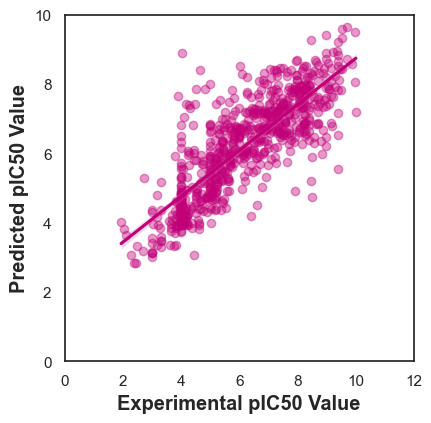

In [98]:
sns.set(color_codes=True)
sns.set_style("white")

results = sns.regplot(x = y_test, y = predictions, scatter_kws={'alpha':0.4}, color = '#C20078')
results.set_xlabel('Experimental pIC50 Value', fontsize='large', fontweight='bold')
results.set_ylabel('Predicted pIC50 Value', fontsize='large', fontweight='bold')
results.set_xlim(0,12)
results.set_ylim(0,10)
results.figure.set_size_inches(4.5,4.5)
plt.show

plt.savefig('stacked_results.pdf')

### Model Results

The stacked model performed better than each individual model. The stacked model will be considered the final and primary model of this project.

In [99]:
# Save the stacked model to disk

filename = 'mmp2_model.sav'
joblib.dump(model, filename)

['mmp2_model.sav']

In [100]:
# Save the stacked model as a pickle object.

pickle.dump(model, open('mmp2_model.pkl', 'wb'))

## 8. Results

In [101]:
# View the final results of the machine learning model with the training and testing sets.

data = ({'Model': "Stacked", 'Mean Absolute Error': mae, 'Mean Squared Error': mse, 'Root Mean Squared Error': rmse, 'R^2 (R Squared)': r2})
results = pd.DataFrame(data, index = [0])
results

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,Stacked,0.75,1.04,1.02,0.67


In [102]:
# View the model performance results without splitting the data.

y_pred = model.predict(X)
y_pred

array([8.65366207, 5.54022076, 3.94602802, ..., 5.24655058, 5.59502924,
       4.6730611 ])

In [103]:
final_mae = mean_absolute_error(y, y_pred)
final_mse = mean_squared_error(y, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y, y_pred)

In [104]:
data = ({'Model': "Final Stacked Model", 'Mean Absolute Error': final_mae, 'Mean Squared Error': final_mse, 'Root Mean Squared Error': final_rmse, 'R^2 (R Squared)': final_r2})
fresults = pd.DataFrame(data, index = [0])
fresults

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R^2 (R Squared)
0,Final Stacked Model,0.56,0.66,0.81,0.80


### Data Visualization

#### Predicted versus Experimental pIC50 Values

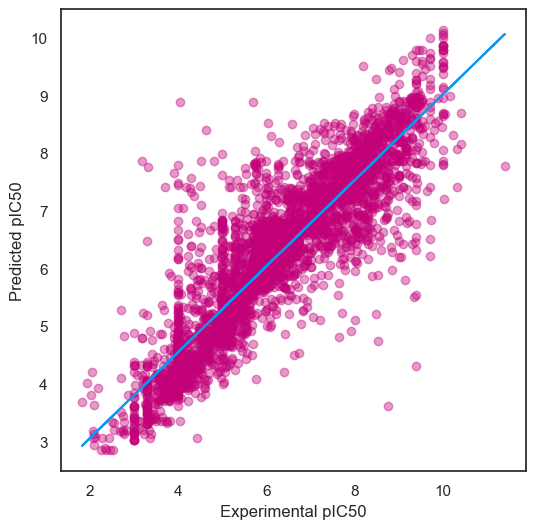

In [105]:
# Create a plot of the predicted versus experimental pIC50 values based on the stacked model.

plt.figure(figsize=(6,6))
plt.scatter(x=y, y=y_pred, c="#C20078", alpha=0.4)

p = np.polyfit(y, y_pred, 1)
line = np.poly1d(p)

plt.plot(y,line(y),"#069AF3")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')

plt.savefig('finalmodel_results.pdf')

### Conclusion

The purpose of this project is to create a machine learning model that can be utilized as an additional tool in the early drug discovery processes for MMP2.

A stacked machine learning regression model was created by utilizing the molecular fingerprint descriptors for MMP2. This model functions by predicting pIC50 values. The results of this project may be utilized as a guideline and/or reference when researching/developing novel drug inhibitors for MMP2.